# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
print(feat_info.shape)

(891221, 85)
(85, 4)


In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
feat_info.head()


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [7]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,PLZ8_ANTG3,person,ordinal,[-1]
freq,1,43,49,26


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
azdias.isnull().sum().sum()

4896838

In [9]:
# Identify missing or unknown data values and convert them to NaNs.
for ind in range(len(feat_info)):
    nanValues = feat_info.iloc[ind]['missing_or_unknown']
    nanValues = nanValues.strip('[')
    nanValues = nanValues.strip(']')
    nanValues = nanValues.split(',')
    
    values=[]
    
    for value in nanValues:
        if (value!='X' and value!='XX' and value!=''):
            values.append(int(value))
        else:
            values.append(value)
    if values != []:
        azdias = azdias.replace({feat_info.iloc[ind]['attribute']: values}, np.nan)


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [10]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
Numbers_Of_Missing_Data=azdias.isnull().sum()
Numbers_Of_Missing_Data

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

(array([ 39.,  40.,   0.,   1.,   1.,   1.,   1.,   1.,   0.,   1.]),
 array([      0. ,   88906.1,  177812.2,  266718.3,  355624.4,  444530.5,
         533436.6,  622342.7,  711248.8,  800154.9,  889061. ]),
 <a list of 10 Patch objects>)

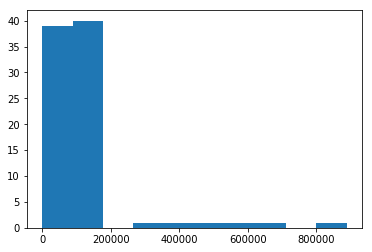

In [11]:
# Investigate patterns in the amount of missing data in each column.

plt.hist(Numbers_Of_Missing_Data)

In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
remove_feat=Numbers_Of_Missing_Data[Numbers_Of_Missing_Data>200000]
remove_feat

AGER_TYP        685843
GEBURTSJAHR     392318
TITEL_KZ        889061
ALTER_HH        310267
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
dtype: int64

In [13]:
azdias=azdias.drop(remove_feat.index, axis=1)

In [14]:
azdias.shape

(891221, 79)

In [15]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

**answer**

In the resulte in the most columns the number of NAs is less than 200000. So I am removed the columns that having NAs more than 200000 because it's outliers, and the appear clear in hist above.

That columns are:

AGER_TYP        
GEBURTSJAHR     
TITEL_KZ        
ALTER_HH        
KK_KUNDENTYP    
KBA05_BAUMAX    


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [16]:
# How much data is missing in each row of the dataset?

Number_Of_Nan_In_Rows=azdias.isnull().sum(axis=1)
Number_Of_Nan_In_Rows

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

In [17]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias_more_5=azdias[Number_Of_Nan_In_Rows>=5]
azdias_Less_5=azdias[Number_Of_Nan_In_Rows<5]


In [18]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

vis=Numbers_Of_Missing_Data[Numbers_Of_Missing_Data==0][:6]
vis=vis.index
vis

Index(['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER'],
      dtype='object')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


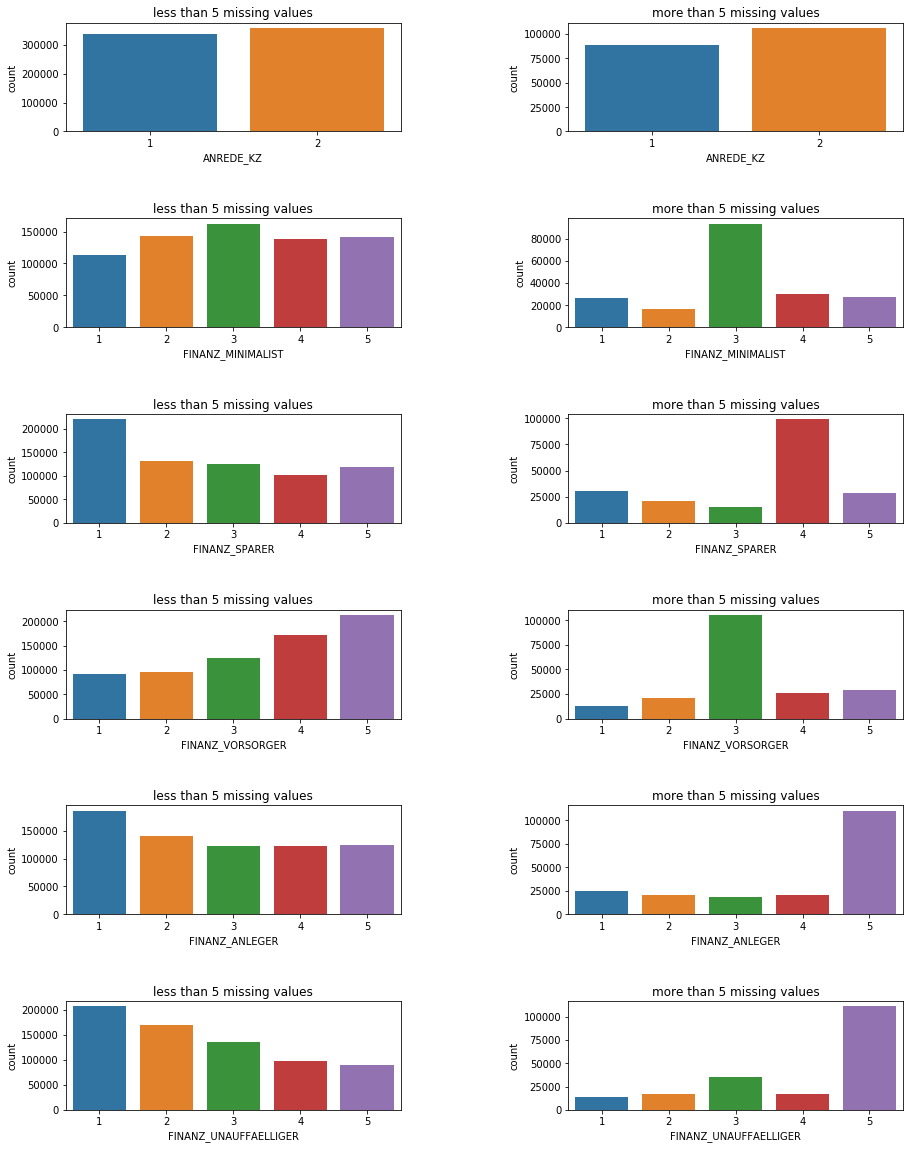

In [19]:
fig, ax =plt.subplots(len(vis),2,figsize = (15,20))

for i in range(len(vis)):
    sns.countplot(azdias_Less_5[vis[i]], ax=ax[i][0])
    ax[i][0].set_title('less than 5 missing values')
    sns.countplot(azdias_more_5[vis[i]], ax=ax[i][1])
    ax[i][1].set_title('more than 5 missing values')
    plt.subplots_adjust(hspace =0.8,wspace= 0.5)
   
fig.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

**Answer:**

The charts above tell us that, the distributions between the two datasets are similar , but are different for some features such as Financial features.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [20]:
# How many features are there of each data type?
feat_info.type.value_counts ()


ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [21]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
feat_info_new=feat_info[feat_info['attribute'].isin(azdias.columns)]
cat_variables=feat_info_new[feat_info_new.type == "categorical"]

malty_cat_list=[]
binary_cat_list=[]
for col in cat_variables['attribute']:
    if len(azdias[col].value_counts())>2:
        malty_cat_list.append(col)
    elif len(azdias[col].value_counts())==2:
        binary_cat_list.append(col)
print("binary variable",binary_cat_list)
print("Multi variable",malty_cat_list)

binary variable ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
Multi variable ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [22]:
# Re-encode categorical variable(s) to be kept in the analysis.
for i in binary_cat_list:
    print(i)
    print(azdias[i].value_counts())

ANREDE_KZ
2    465305
1    425916
Name: ANREDE_KZ, dtype: int64
GREEN_AVANTGARDE
0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
SOHO_KZ
0.0    810834
1.0      6888
Name: SOHO_KZ, dtype: int64
VERS_TYP
2.0    398722
1.0    381303
Name: VERS_TYP, dtype: int64
OST_WEST_KZ
W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64


In [23]:
azdias['OST_WEST_KZ']=azdias['OST_WEST_KZ'].map({'W':0,'O':1})
azdias['OST_WEST_KZ'].value_counts()

0.0    629528
1.0    168545
Name: OST_WEST_KZ, dtype: int64

In [24]:

for f in malty_cat_list:
    azdias=azdias.drop(f, axis=1)


In [25]:
azdias['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    188697
8.0     145988
5.0      86416
10.0     85808
3.0      55195
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      21282
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

**answer**

I dropped all multi-level features, and re-encoded the values in 'OST_WEST_KZ' (binary level feature) to number and found the rest of binary features numbers so i kept it.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [26]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias['DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE']
azdias['MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE']

In [27]:
azdias['DECADE']=azdias['DECADE'].map({1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6})
azdias['MOVEMENT']=azdias['MOVEMENT'].map({1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0})

In [28]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias['WEALTH'] = azdias['CAMEO_INTL_2015']
azdias['LIFE_STAGE'] = azdias['CAMEO_INTL_2015']

In [29]:

azdias['WEALTH']=azdias['WEALTH'].map({'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5})
azdias['LIFE_STAGE']=azdias['LIFE_STAGE'].map({'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5})

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)


**answer**

I kept the features:

* PRAEGENDE_JUGENDJAHRE
* CAMEO_INTL_2015

such that created two new feature columns for each of them, and copied values from the initial mixed-value features columns, after that mapped the values on it with the new values. 

The other mixed features I decide to drop it !

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [30]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [31]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Drop the mixed features
mix_variables=feat_info_new[feat_info_new.type == "mixed"]['attribute']
for mf in mix_variables:
    azdias=azdias.drop(mf, axis=1)
azdias


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,2.0,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0.0,5.0,5.0,4.0,6.0,3.0,5.0,1.0,2.0,2.0
7,1.0,1,3,3,4,1,3,2,0,1.0,...,0.0,4.0,4.0,2.0,5.0,2.0,4.0,1.0,1.0,4.0
8,3.0,1,4,4,2,4,2,2,1,3.0,...,1.0,3.0,3.0,2.0,4.0,3.0,5.0,0.0,1.0,3.0
9,3.0,2,2,4,2,3,5,4,1,2.0,...,1.0,3.0,3.0,2.0,3.0,1.0,6.0,0.0,1.0,5.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [67]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for ind in range(len(feat_info)):
        nanValues = feat_info.iloc[ind]['missing_or_unknown']
        nanValues = nanValues.strip('[')
        nanValues = nanValues.strip(']')
        nanValues = nanValues.split(',')

        values=[]

        for value in nanValues:
            if (value!='X' and value!='XX' and value!=''):
                values.append(int(value))
            else:
                values.append(value)
        if values != []:
            df = df.replace({feat_info.iloc[ind]['attribute']: values}, np.nan)

    
    # remove selected columns and rows, ...
    
    FNumbers_Of_Missing_Data=df.isnull().sum()
    Fremove_feat=FNumbers_Of_Missing_Data[Numbers_Of_Missing_Data>200000]
    df=df.drop(Fremove_feat.index, axis=1)
    
    # select, re-encode, and engineer column values.
    feat_info_new=feat_info[feat_info['attribute'].isin(df.columns)]
    cat_variables=feat_info_new[feat_info_new.type == "categorical"]

    malty_cat_list=[]
    binary_cat_list=[]
    for col in cat_variables['attribute']:
        if len(df[col].value_counts())>2:
            malty_cat_list.append(col)
        elif len(df[col].value_counts())==2:
            binary_cat_list.append(col)
    print("binary variable",binary_cat_list)
    print("Multi variable",malty_cat_list)
    df['OST_WEST_KZ']=df['OST_WEST_KZ'].map({'W':0,'O':1})
    df['OST_WEST_KZ'].value_counts()
    for f in malty_cat_list:
        df=df.drop(f, axis=1)

    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE']
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE']
    df['DECADE']=df['DECADE'].map({1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6})
    df['MOVEMENT']=df['MOVEMENT'].map({1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0})
    df['WEALTH'] = df['CAMEO_INTL_2015']
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015']
    df['WEALTH']=df['WEALTH'].map({'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
                   '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
                   '51':5, '52':5, '53':5, '54':5, '55':5})
    df['LIFE_STAGE']=df['LIFE_STAGE'].map({'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                       '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                       '51':1, '52':2, '53':3, '54':4, '55':5})
    fmix_variables=feat_info_new[feat_info_new.type == "mixed"]['attribute']
    for mf in fmix_variables:
        df=df.drop(mf, axis=1)
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [59]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

missing_filling=Imputer(strategy='median')
azdias_imp = pd.DataFrame(missing_filling.fit_transform(azdias))
azdias_imp.columns= azdias.columns
azdias_imp.index= azdias.index

In [62]:
azdias.shape

(891221, 64)

In [66]:
customers_cleaned.shape

(191652, 70)

In [60]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scale = scaler.fit_transform(azdias_imp)
azdias_scale = pd.DataFrame(azdias_scale, columns=list(azdias_imp))
azdias_scale

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-0.751680,-1.045218,-0.056416,0.804890,-0.303378,1.285741,1.429871,-0.055511,-0.494701,-0.234601,...,0.381488,0.366863,-0.317206,-0.157224,-0.120115,-0.049267,-0.213102,0.494701,0.468366,0.080573
1,-1.743339,0.956738,-1.570358,1.487601,-1.059731,1.285741,0.757254,1.422415,-0.494701,1.175204,...,0.381488,1.456896,0.640354,-0.157224,-0.120115,0.729399,1.244436,0.494701,1.182728,-1.347861
2,0.239980,0.956738,-1.570358,0.804890,-1.816084,-0.675554,0.084637,1.422415,2.021423,1.175204,...,-1.077335,0.366863,0.640354,-0.157224,-0.120115,-0.827934,1.244436,-2.021423,-0.960358,0.794789
3,1.231640,0.956738,0.700556,-0.560532,1.209329,-0.675554,-1.260597,-0.794475,-0.494701,-0.234601,...,-1.077335,-0.723171,0.640354,-1.216157,-1.039247,-0.049267,-0.213102,0.494701,-1.674720,-0.633644
4,0.239980,-1.045218,0.700556,0.122179,0.452976,-1.329319,0.084637,-0.794475,-0.494701,1.175204,...,0.381488,-0.723171,-0.317206,0.901709,0.339451,1.508065,-0.213102,0.494701,0.468366,0.080573
5,-1.743339,0.956738,-0.056416,-1.243244,1.209329,-0.675554,-0.587980,1.422415,-0.494701,1.175204,...,0.381488,1.456896,1.597913,-1.216157,-1.039247,-0.049267,-1.670640,0.494701,1.182728,0.794789
6,-0.751680,0.956738,-1.570358,1.487601,-1.816084,1.285741,0.757254,-0.055511,-0.494701,-0.234601,...,-1.077335,1.456896,1.597913,0.901709,0.339451,-0.049267,0.515667,0.494701,-0.960358,-0.633644
7,-1.743339,-1.045218,-0.056416,0.122179,0.452976,-1.329319,0.084637,-0.794475,-0.494701,-1.644405,...,-1.077335,0.366863,0.640354,-1.216157,-0.120115,-0.827934,-0.213102,0.494701,-1.674720,0.794789
8,0.239980,-1.045218,0.700556,0.804890,-1.059731,0.631976,-0.587980,-0.794475,2.021423,1.175204,...,0.381488,-0.723171,-0.317206,-1.216157,-0.579681,-0.049267,0.515667,-2.021423,-1.674720,0.080573
9,0.239980,0.956738,-0.813387,0.804890,-1.059731,-0.021789,1.429871,0.683452,2.021423,-0.234601,...,0.381488,-0.723171,-0.317206,-1.216157,-1.039247,-1.606600,1.244436,-2.021423,-1.674720,1.509006


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)


 **answer**
 
 Deal with nan values such that imputed it using the median value per column , because it is more robust against outliers.
 
Achieved a mean of 0 and standard deviation of 1 by using StandardScaler to scaling the features

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [35]:
# Apply PCA to the data.
pca = PCA(60)
pca_ft=pca.fit_transform(azdias_scale)


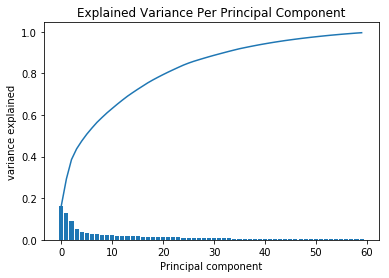

In [36]:
# Investigate the variance accounted for by each principal component.

plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_))
plt.title("Explained Variance Per Principal Component")
plt.xlabel("Principal component")
plt.ylabel("variance explained")
plt.show()

In [37]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_35 = PCA(n_components=35)
pca_35_ft=pca_35.fit_transform(azdias_scale)


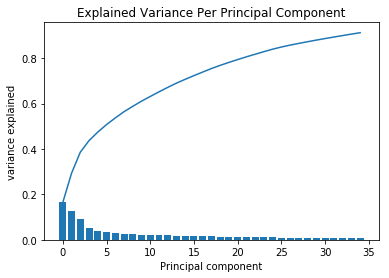

In [38]:
plt.bar(range(len(pca_35.explained_variance_ratio_)), pca_35.explained_variance_ratio_)
plt.plot(range(len(pca_35.explained_variance_ratio_)),np.cumsum(pca_35.explained_variance_ratio_))
plt.title("Explained Variance Per Principal Component")
plt.xlabel("Principal component")
plt.ylabel("variance explained")
plt.show()

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

**answer**

I decided to take 35 principal components, as shown above (35 principal components) expalains more than 85% variances also reducing the number of features to be around half of the number of original features

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [39]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def view_weights(pca, i):

    df = pd.DataFrame(pca.components_, columns=list(azdias.columns))
    weights = df.iloc[i].sort_values(ascending=False)
    return weights


In [40]:
azdias

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,2.0,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0.0,5.0,5.0,4.0,6.0,3.0,5.0,1.0,2.0,2.0
7,1.0,1,3,3,4,1,3,2,0,1.0,...,0.0,4.0,4.0,2.0,5.0,2.0,4.0,1.0,1.0,4.0
8,3.0,1,4,4,2,4,2,2,1,3.0,...,1.0,3.0,3.0,2.0,4.0,3.0,5.0,0.0,1.0,3.0
9,3.0,2,2,4,2,3,5,4,1,2.0,...,1.0,3.0,3.0,2.0,3.0,1.0,6.0,0.0,1.0,5.0


In [41]:
#first principal component
view_weights(pca_35, 0)

PLZ8_ANTG3               0.231829
PLZ8_ANTG4               0.224933
WEALTH                   0.210405
ORTSGR_KLS9              0.200699
EWDICHTE                 0.200597
HH_EINKOMMEN_SCORE       0.173745
FINANZ_HAUSBAUER         0.161879
PLZ8_ANTG2               0.158707
KBA05_ANTG4              0.152589
ARBEIT                   0.144653
FINANZ_SPARER            0.142820
RELAT_AB                 0.138045
ANZ_HAUSHALTE_AKTIV      0.135875
KBA05_ANTG3              0.131967
SEMIO_PFLICHT            0.111940
MOVEMENT                 0.111850
SEMIO_REL                0.105984
SEMIO_RAT                0.092079
DECADE                   0.091884
SEMIO_TRADV              0.079221
SEMIO_MAT                0.076116
SEMIO_FAM                0.074151
FINANZ_UNAUFFAELLIGER    0.073885
REGIOTYP                 0.071026
FINANZ_ANLEGER           0.070413
SEMIO_KULT               0.057608
SEMIO_KAEM               0.052172
OST_WEST_KZ              0.049258
PLZ8_HHZ                 0.045391
KKK           

In [42]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

view_weights(pca_35,1)


ALTERSKATEGORIE_GROB     0.268383
FINANZ_VORSORGER         0.247677
SEMIO_ERL                0.224930
SEMIO_LUST               0.185816
RETOURTYP_BK_S           0.172535
W_KEIT_KIND_HH           0.127488
FINANZ_HAUSBAUER         0.113958
ORTSGR_KLS9              0.092661
EWDICHTE                 0.091506
PLZ8_ANTG3               0.083493
FINANZ_MINIMALIST        0.082461
PLZ8_ANTG4               0.079659
KBA05_ANTG4              0.077487
ARBEIT                   0.070415
SEMIO_KAEM               0.069749
SEMIO_KRIT               0.068883
ANZ_HAUSHALTE_AKTIV      0.067186
HH_EINKOMMEN_SCORE       0.065876
RELAT_AB                 0.065844
WEALTH                   0.063486
ANREDE_KZ                0.060117
PLZ8_ANTG2               0.058727
WOHNDAUER_2008           0.055409
KBA05_ANTG3              0.053173
SEMIO_DOM                0.035507
ANZ_HH_TITEL             0.034174
OST_WEST_KZ              0.033588
VERS_TYP                 0.016935
REGIOTYP                 0.010624
ANZ_TITEL     

In [43]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
view_weights(pca_35,2)


SEMIO_VERT               0.353697
SEMIO_SOZ                0.291287
SEMIO_KULT               0.279031
SEMIO_FAM                0.231627
FINANZ_MINIMALIST        0.129503
RETOURTYP_BK_S           0.081797
W_KEIT_KIND_HH           0.069842
SEMIO_MAT                0.066601
FINANZ_VORSORGER         0.064825
GREEN_AVANTGARDE         0.062958
SEMIO_REL                0.052894
ORTSGR_KLS9              0.048930
ALTERSKATEGORIE_GROB     0.042968
EWDICHTE                 0.041459
KBA05_ANTG4              0.040639
ARBEIT                   0.039419
OST_WEST_KZ              0.034204
ANZ_HAUSHALTE_AKTIV      0.033389
HH_EINKOMMEN_SCORE       0.031168
RELAT_AB                 0.030806
KBA05_ANTG3              0.029851
PLZ8_ANTG4               0.028463
PLZ8_ANTG3               0.027305
ANZ_PERSONEN             0.019778
PLZ8_ANTG2               0.018378
SEMIO_LUST               0.017636
ANZ_HH_TITEL             0.016042
ANZ_TITEL                0.010818
WEALTH                   0.008851
SOHO_KZ       

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

**answer**

we can conclosion from the first principal component that:

*  PLZ8_ANTG3 and PLZ8_ANTG4 have a positive correlation. Such that if PLZ8_ANTG3 increased then PLZ8_ANTG4 will increase and if PLZ8_ANTG3 decreased then PLZ8_ANTG4 will decrease.

* Also PLZ8_ANTG3 and ORTSGR_KLS9 have a positive correlation. This indicates that if PLZ8_ANTG3 increased then ORTSGR_KLS9 will increase and if PLZ8_ANTG3 decreased then ORTSGR_KLS9 will decrease.
* KBA05_ANTG1 and PLZ8_ANTG4 have a negative correlation. That means that if KBA05_ANTG1 increased then PLZ8_ANTG4 will decrease and if KBA05_ANTG1 decreased then PLZ8_ANTG4 will increase.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [47]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    
      # compute the average within-cluster distances.
scores_of_k = []

for ks in range(10,31,4):
    kmean = KMeans(ks)
    kmean.fit(pca_35_ft)
    scores_of_k.append(np.abs(kmean.score(pca_35_ft)))
    

    

In [48]:
np.arange(10, 31, 4)

array([10, 14, 18, 22, 26, 30])

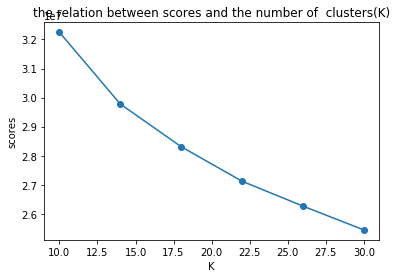

In [49]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(np.arange(10, 31, 4), scores_of_k, linestyle='-', marker='o');
plt.xlabel('K');
plt.ylabel('scores');
plt.title('the relation between scores and the number of  clusters(K)');



In [52]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 18)
model = kmeans.fit(pca_35_ft)
azdias_labels = model.predict(pca_35_ft)


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

**answer**

I segment the population to 18 clusters because after 18 clusters, the average distance decrease is smaller than before one.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [53]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',';')

In [68]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_cleaned = clean_data(customers)


binary variable ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
Multi variable ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [69]:

customers_imp = pd.DataFrame(missing_filling.fit_transform(customers_cleaned))
customers_imp.columns = customers_cleaned.columns
customers_imp.index = customers_cleaned.index
customers_imp

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0.0,5.0,5.0,1.0,2.0,1.0,2.0,0.0,1.0,3.0
1,4.0,1.0,5.0,1.0,5.0,1.0,3.0,2.0,0.0,1.0,...,0.0,3.0,4.0,3.0,5.0,3.0,3.0,1.0,2.0,4.0
2,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,1.0,3.0,2.0,3.0,5.0,3.0,2.0,0.0,3.0,4.0
3,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,3.0,4.0,1.0,3.0,1.0,1.0,1.0,2.0,4.0
4,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,1.0,3.0,3.0,3.0,5.0,1.0,4.0,1.0,4.0,1.0
5,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,1.0,5.0,5.0,3.0,7.0,5.0,2.0,0.0,3.0,4.0
6,4.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,2.0,...,0.0,5.0,5.0,2.0,3.0,2.0,2.0,0.0,2.0,3.0
7,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,1.0,3.0,3.0,3.0,4.0,3.0,2.0,0.0,1.0,5.0
8,4.0,2.0,2.0,2.0,5.0,1.0,1.0,5.0,0.0,2.0,...,1.0,5.0,4.0,3.0,8.0,3.0,1.0,1.0,5.0,5.0
9,3.0,1.0,5.0,2.0,4.0,1.0,3.0,1.0,1.0,3.0,...,0.0,5.0,5.0,3.0,6.0,4.0,4.0,0.0,1.0,5.0


In [70]:

customers_scale = scaler.transform(customers_imp)
customers_scale = pd.DataFrame(customers_scale, columns=list(customers_imp))


In [71]:

customers_pca = pca_35.transform(customers_scale)


In [72]:

customers_labels = model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'azdias Clusters')

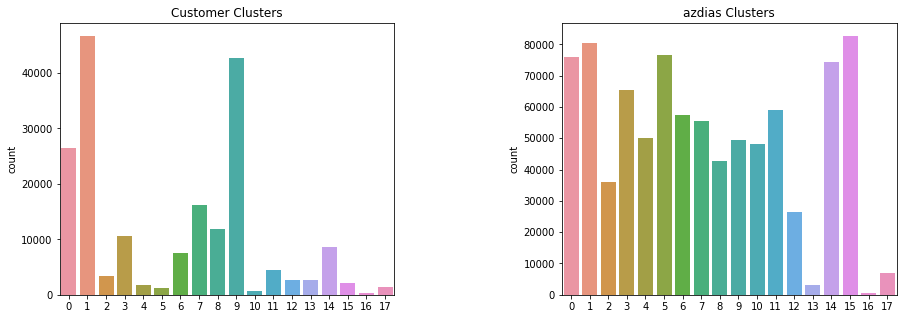

In [78]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig, ax = plt.subplots(1, 2, figsize = (15,5))
fig.subplots_adjust(hspace = 1.5, wspace=0.5)

sns.countplot(customers_labels, ax=ax[0])
ax[0].set_title('Customer Clusters')
sns.countplot(azdias_labels, ax=ax[1])
ax[1].set_title('azdias Clusters')


In [84]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
overrepresented = scaler.inverse_transform(pca_35.inverse_transform(model.cluster_centers_[1]))

overrepresented_1 = pd.Series(data = overrepresented, index = customers_cleaned.columns)

print(overrepresented_1)


ALTERSKATEGORIE_GROB        2.359896
ANREDE_KZ                   1.577027
FINANZ_MINIMALIST           2.899424
FINANZ_SPARER               4.043164
FINANZ_VORSORGER            2.983513
FINANZ_ANLEGER              4.973563
FINANZ_UNAUFFAELLIGER       4.937427
FINANZ_HAUSBAUER            3.077034
GREEN_AVANTGARDE            0.003471
HEALTH_TYP                  1.994320
RETOURTYP_BK_S              3.281340
SEMIO_SOZ                   1.993920
SEMIO_FAM                   5.879489
SEMIO_REL                   6.886516
SEMIO_MAT                   4.988125
SEMIO_VERT                  1.178987
SEMIO_LUST                  5.090696
SEMIO_ERL                   3.084455
SEMIO_KULT                  3.095525
SEMIO_RAT                   4.011588
SEMIO_KRIT                  7.074883
SEMIO_DOM                   5.878734
SEMIO_KAEM                  5.789720
SEMIO_PFLICHT               5.198288
SEMIO_TRADV                 2.907674
SOHO_KZ                    -0.000076
VERS_TYP                    2.000447
A

In [90]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
underrepresented = scaler.inverse_transform(pca_35.inverse_transform(model.cluster_centers_[15]))

underrepresented_15 = pd.Series(data = underrepresented, index = customers_cleaned.columns)

print(underrepresented_15)


ALTERSKATEGORIE_GROB        1.722939
ANREDE_KZ                   1.973981
FINANZ_MINIMALIST           2.321750
FINANZ_SPARER               3.971228
FINANZ_VORSORGER            2.259297
FINANZ_ANLEGER              4.408013
FINANZ_UNAUFFAELLIGER       3.908047
FINANZ_HAUSBAUER            2.798259
GREEN_AVANTGARDE            0.185682
HEALTH_TYP                  2.265643
RETOURTYP_BK_S              2.455634
SEMIO_SOZ                   2.645136
SEMIO_FAM                   3.742018
SEMIO_REL                   5.200128
SEMIO_MAT                   5.168972
SEMIO_VERT                  2.575330
SEMIO_LUST                  2.948348
SEMIO_ERL                   4.403497
SEMIO_KULT                  4.027690
SEMIO_RAT                   6.266807
SEMIO_KRIT                  5.384208
SEMIO_DOM                   5.978962
SEMIO_KAEM                  5.662112
SEMIO_PFLICHT               5.940238
SEMIO_TRADV                 5.865328
SOHO_KZ                     0.000024
VERS_TYP                    1.462741
A

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)


**answer**


From the analysis above, it can be seen that

The overrepresented cluster is cluster number (1) such that customers data compared to general population data. 
Some features of the population that are relatively popular with the mail-order company:


* in a field where the share of 6-10 family homes is lower (PLZ8_ANTG3 = 1.979855)

* in the density of households per square kilometer which is higher(EWDICHTE = 4.021635)

* in the number of adults in household which is lower (ANZ_PERSONEN = 1.047162)

The underrepresented cluster is cluster number (15) such that Some features of the segment of the population that are relatively unpopular with the company:


* in a field where the share of 6-10 family homes is higher (PLZ8_ANTG3=1.047519)

* in the density of households per square kilometer is lower(EWDICHTE = 3.000289)

* in the number of adults in household which is higher (ANZ_PERSONEN = 1.950233)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.